# Supplement 4: Interaction Terms Model

Source code for prediction of COVID-19 test results. This is supplemental material to publication

Wojtusiak J, Bagais W, Vang J, Guralnik E, Roess A, Alemi F, "The Role of Symptom Clusters in Triage of COVID-19 Patients," Quality Management in Health Care, 2022.

Source code by Wejdan Bagais and Jee Vang with contribution of other authors. 

In [1]:
# import libraries
from models import select_attributes
from models import conjunction_columns

import pandas as pd
import numpy as np
import timeit

from patsy import dmatrix, dmatrices

import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
from joblib import Parallel, delayed

import matplotlib.pyplot as plt

## Run LASSO model for the 30 splits data

In [ ]:
start = timeit.default_timer()

#list of inverse of regularization
c_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,2]

split_ids = []
cs = []
source = []
AUCs = []
prec = []
rec =  []
vars_cnt = []
vars_lists = []
ys_test = []
ys_pred = []

# loop over the 30 split data
for i in range (0,30):
    # read the data
    tr_path = "../data/30_splits_data/binary-transformed_tr_"+str(i)+".csv"
    ts_path= "../data/30_splits_data/binary-transformed_ts_"+str(i)+".csv"

    train = pd.read_csv(tr_path)
    test = pd.read_csv(ts_path)
     
    # create the single, pair, and triplets clusters
    XT, Xt, yT, yt = conjunction_columns(train, test)
    
    # loop over inverse of regularization
    for c in c_list:
        # run the model
        auc, recall, precision, valid_cols, yt, y_pred = select_attributes(XT, yT, Xt, yt,c)
        # save results to the list
        split_ids.append(i)
        cs.append(c)
        source.append('conjunction')
        AUCs.append(auc)
        prec.append(precision)
        rec.append(recall)
        vars_lists.append(valid_cols)
        vars_cnt.append(len(valid_cols))
        ys_test.append(yt.values.tolist())
        ys_pred.append(y_pred)
                
        print(f'ID {i}, C={c:.2f}, AUC={auc:.5f}, Precision={precision:.5f}, Recall={recall:.5f}, cls# {len(valid_cols)}') 

stop = timeit.default_timer()
print('Time: ', stop - start)  

In [16]:
# identify the list of unique selected predictors
unq_var = vars_lists.copy()
for i in range(0, len(unq_var)):
    unq_var[i] = [sub.replace(' & ', ',') for sub in unq_var[i]]
    
sympt_lists = []
for i in range(0, len(unq_var)):
    l = ",".join(unq_var[i])
    l2 = list(set(l.split(',')))
    sympt_lists.append(l2)

In [18]:
ys_pred_l = []
for i in ys_pred:
    ys_pred_l.append(list(i))

In [ ]:
# create dataframe for all results
ff = pd.DataFrame({'split_ids'    : split_ids,
                   'cs'           : cs,
                   'source'       : source,
                   'AUCs'         : AUCs,
                   'prec'         : prec,
                   'rec'          : rec,
                   'vars_cnt'     : vars_cnt,
                   'vars_lists'   : vars_lists,
                   'y_test'       : ys_test,
                   'y_pred'       : ys_pred_l
                  })

In [ ]:
# add list of unique predictors and its count
ff['sympt_lists'] = sympt_lists
ff['sympt_cnt'] = ff['sympt_lists'].apply(lambda x :len(x))

In [23]:
# save the results
ff.to_csv('../data/results/interaction_terms.csv', index = False)

## Identifying the best inverse of regularization strength value (C)

In [24]:
table = pd.pivot_table(ff, values=['AUCs', 'vars_cnt', 'sympt_cnt']
                       , index=['cs']
                       , aggfunc=np.mean).round(decimals =4)

table['sympt_cnt'] = table['sympt_cnt'].round().astype(int)
table['vars_cnt'] = table['vars_cnt'].round().astype(int)

In [25]:
table

AUCs  sympt_cnt  vars_cnt
cs                              
0.1  0.7800          8         5
0.2  0.7863         12         9
0.3  0.8040         15        14
0.4  0.8143         17        18
0.5  0.8147         20        25
0.6  0.8144         23        32
0.7  0.8138         25        38
0.8  0.8144         27        45
0.9  0.8166         28        52
1.0  0.8170         29        58
1.5  0.8115         33        94
2.0  0.8071         35       130

In [27]:
column = table["AUCs"]
best_c = column.idxmax() 
best_c

1.0

In [8]:
# C = 1 has the highest AUC; 
# however, C = 0.4 has similar AUC values 
# with much less number of selected variables 
_C = 0.4

## Build model based on the selected C and using all data to identify the list of predictors

In [4]:
path = "../data/preprocessed.csv"
df = pd.read_csv(path)

### create the single, pair, and triplets clusters
- The purpose of the model is to identify the list of predictors. Since we already measured the performance in the previous step, we will train the model using all the data.

In [5]:
X, Xt, y, yt = conjunction_columns(df, df)

In [30]:
symptoms = df.columns.tolist()
symptoms.remove('TestPositive')

In [31]:
symptom_interactions = ' + '.join(symptoms)

formula = f'TestPositive ~  ({symptom_interactions}) ** 3'

include_columns = symptoms + ['TestPositive']  
y, X = dmatrices(formula, df[include_columns], return_type='dataframe')

In [32]:
X = X.drop(columns=['Intercept'])

In [33]:
X.columns  = [s.replace('_',' ') for s in X.columns]

X.columns = X.columns.str.replace(":", " & ")

### k-fold cross-validation, k=24

In [6]:
Xy_pickle = 'BinaryDataX_pairs_triples.p'
pickle.dump({'X': X, 'y': y}, open(Xy_pickle, 'wb'))

In [9]:
def do_validation(fold, tr, te, c= _C):
    data = pickle.load(open(Xy_pickle, 'rb'))
    X, y = data['X'], data['y']
    
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr].values.ravel(), y.iloc[te].values.ravel()
    
    print(f'fold {fold:02}')
        
    regressor = LogisticRegression(penalty='l1', solver='saga', C=c, n_jobs=-1, max_iter=5000*2)
    regressor.fit(X_tr, y_tr)
    
    y_pr = regressor.predict_proba(X_te)[:,1]
    
    score = roc_auc_score(y_te, y_pr)
    print(f'fold {fold:02}, score={score:.5f}')
    return score, regressor.coef_[0]
    

skf = StratifiedKFold(n_splits=24, shuffle=True, random_state=37)

In [10]:
outputs = Parallel(n_jobs=-1)(delayed(do_validation)(fold, tr, te, _C) 
                              for fold, (tr, te) in enumerate(skf.split(X, y)))

In [11]:
scores = pd.Series([score for score, _ in outputs])
coefs = pd.DataFrame([coef for _, coef in outputs], columns=X.columns)

## Coefficients from k-fold cross-validation that is consistent 95% of the time
- Consistent means in same direction and not absent.

In [12]:
def get_profile(df, col):
    s = df[col]
    
    s_pos = s[s > 0]
    s_neg = s[s < 0]
    
    n = df.shape[0]
    p_pos = len(s_pos) / n
    p_neg = len(s_neg) / n
    
    return {
        'field': col,
        'n_pos': len(s_pos),
        'n_neg': len(s_neg),
        'pct_pos': p_pos, 
        'pct_neg': p_neg, 
        'is_valid': 1 if p_pos >= 0.95 or p_neg >= 0.95 else 0
    }

In [13]:
valid_coefs = pd.DataFrame([get_profile(coefs, c) for c in coefs.columns]).sort_values(['is_valid'], ascending=False)
valid_coefs = valid_coefs[valid_coefs.is_valid == 1]

In [14]:
valid_cols = list(valid_coefs.field)
regressor = LogisticRegression(penalty='l1', solver='saga', C= _C, n_jobs=-1, 
                               max_iter=5000*2, random_state=37)
regressor.fit(X[valid_cols], y.values.ravel())

LogisticRegression(C=0.4, max_iter=10000, n_jobs=-1, penalty='l1',
                   random_state=37, solver='saga')

In [15]:
y_pred = regressor.predict_proba(X[valid_cols])[:,1]

t = X[valid_cols].copy()
t['y_pred'] = y_pred
t['y_actual'] = y
t.to_csv("../data/results/prediction_interaction_terms.csv", index=False)

### Visualize coefficients

In [16]:
c = pd.Series(regressor.coef_[0], valid_cols)

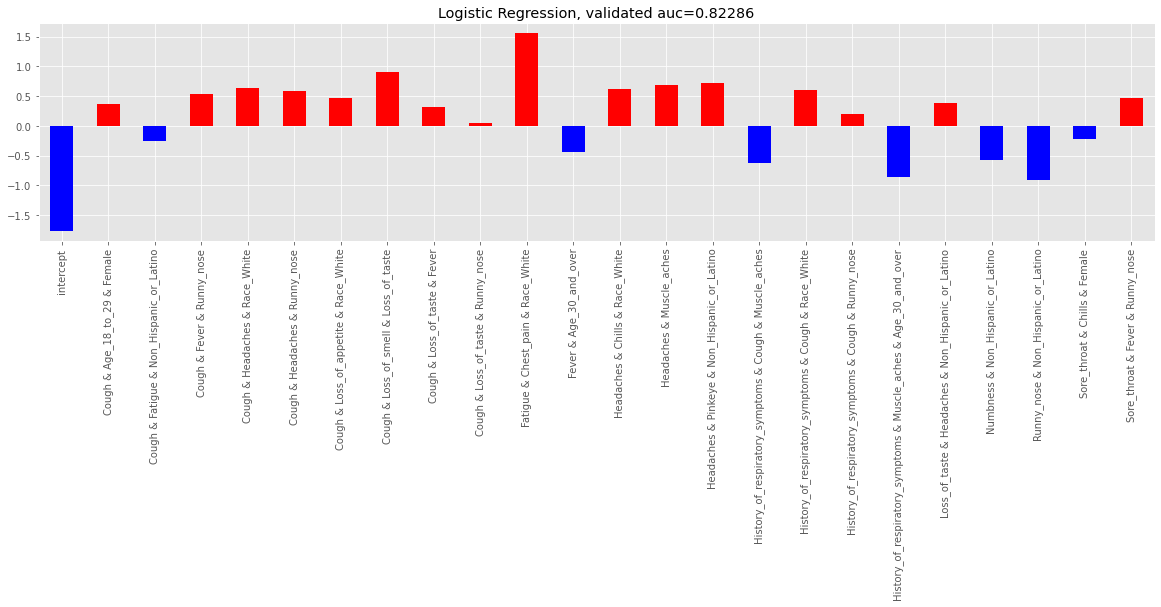

In [18]:
plt.style.use('ggplot')

i = pd.Series([regressor.intercept_[0]], index=['intercept'])
s = pd.concat([c[c > 0], c[c < 0]]).sort_index()
s = pd.concat([i, s])
color = ['r' if v > 0 else 'b' for v in s]

ax = s.plot(kind='bar', color=color, figsize=(20, 4))
_ = ax.set_title(f'Logistic Regression, validated auc={scores.mean():.5f}')

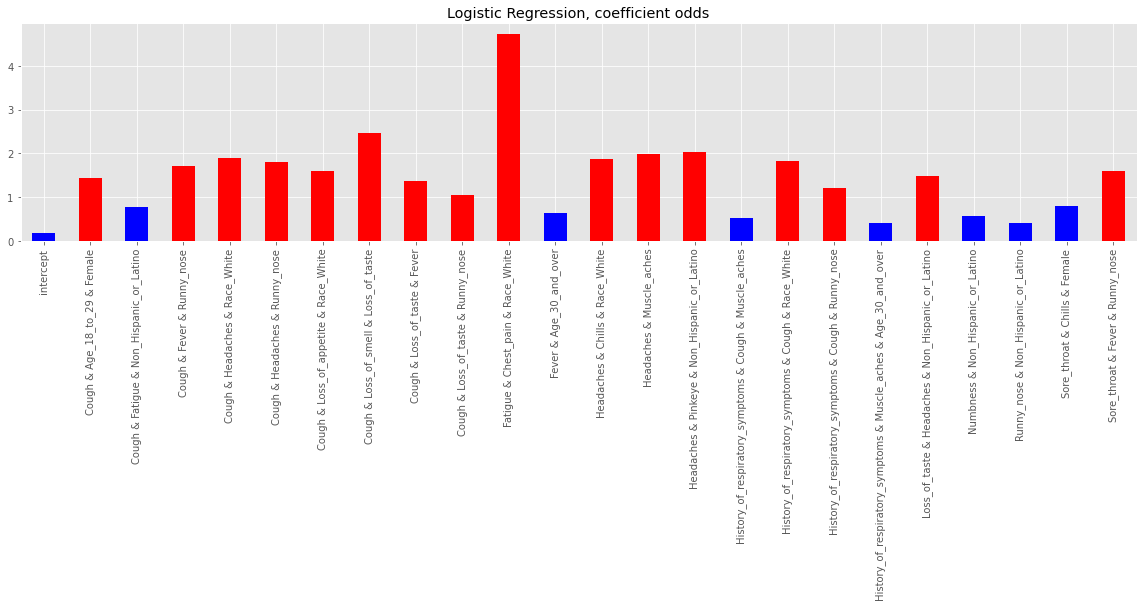

In [19]:
s_odds = np.exp(s)
color = ['r' if v > 1 else 'b' for v in s_odds]

ax = s_odds.plot(kind='bar', color=color, figsize=(20, 4))
_ = ax.set_title(f'Logistic Regression, coefficient odds')

### Tabular output of coefficients with odds

In [20]:
pd.DataFrame({
    'coefficient': s,
    'coefficient_odds': s_odds
}).round(decimals=4)

coefficient  \
intercept                                               -1.7669   
Cough & Age_18_to_29 & Female                            0.3608   
Cough & Fatigue & Non_Hispanic_or_Latino                -0.2603   
Cough & Fever & Runny_nose                               0.5409   
Cough & Headaches & Race_White                           0.6375   
Cough & Headaches & Runny_nose                           0.5911   
Cough & Loss_of_appetite & Race_White                    0.4745   
Cough & Loss_of_smell & Loss_of_taste                    0.9050   
Cough & Loss_of_taste & Fever                            0.3199   
Cough & Loss_of_taste & Runny_nose                       0.0550   
Fatigue & Chest_pain & Race_White                        1.5554   
Fever & Age_30_and_over                                 -0.4427   
Headaches & Chills & Race_White                          0.6258   
Headaches & Muscle_aches                                 0.6852   
Headaches & Pinkeye & Non_Hispanic_or_Latino             0.7138   
History_of_respiratory_symptoms & Cough & Muscl...      -0.6269   
History_of_respiratory_symptoms & Cough & Race_...       0.5975   
History_of_respiratory_symptoms & Cough & Runny...       0.1993   
History_of_respiratory_symptoms & Muscle_aches ...      -0.8643   
Loss_of_taste & Headaches & Non_Hispanic_or_Latino       0.3909   
Numbness & Non_Hispanic_or_Latino                       -0.5733   
Runny_nose & Non_Hispanic_or_Latino                     -0.9138   
Sore_throat & Chills & Female                           -0.2131   
Sore_throat & Fever & Runny_nose                         0.4726   

                                                    coefficient_odds  
intercept                                                     0.1709  
Cough & Age_18_to_29 & Female                                 1.4345  
Cough & Fatigue & Non_Hispanic_or_Latino                      0.7708  
Cough & Fever & Runny_nose                                    1.7175  
Cough & Headaches & Race_White                                1.8917  
Cough & Headaches & Runny_nose                                1.8059  
Cough & Loss_of_appetite & Race_White                         1.6073  
Cough & Loss_of_smell & Loss_of_taste                         2.4718  
Cough & Loss_of_taste & Fever                                 1.3769  
Cough & Loss_of_taste & Runny_nose                            1.0566  
Fatigue & Chest_pain & Race_White                             4.7370  
Fever & Age_30_and_over                                       0.6423  
Headaches & Chills & Race_White                               1.8698  
Headaches & Muscle_aches                                      1.9841  
Headaches & Pinkeye & Non_Hispanic_or_Latino                  2.0418  
History_of_respiratory_symptoms & Cough & Muscl...            0.5342  
History_of_respiratory_symptoms & Cough & Race_...            1.8175  
History_of_respiratory_symptoms & Cough & Runny...            1.2206  
History_of_respiratory_symptoms & Muscle_aches ...            0.4213  
Loss_of_taste & Headaches & Non_Hispanic_or_Latino            1.4783  
Numbness & Non_Hispanic_or_Latino                             0.5637  
Runny_nose & Non_Hispanic_or_Latino                           0.4010  
Sore_throat & Chills & Female                                 0.8081  
Sore_throat & Fever & Runny_nose                              1.6041

In [21]:
(pd.DataFrame({
    'coefficient': s,
    'coefficient_odds': s_odds
}).round(decimals=4)).shape

(24, 2)